In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import datetime
import re

# Moore's Law

In [249]:
data_bm = pd.read_csv('./benchmarks.txt', sep=",")
data_sm = pd.read_csv('./summaries.txt', sep=",", encoding = "ISO-8859-1")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [252]:
#transform base values to floats
omnetpp = data_bm.loc[data_bm["benchName"]=="101.tomcatv"]
omnetpp_merged = pd.merge(omnetpp, data_sm, left_on='testID', right_on='testID', how='left').drop(['tester', 'machine', 'cpu', 'mhz', 'os', 'compiler', 'autoParallel', 'benchType', 'peak_x', 'peak_y'], axis=1)
omnetpp_merged["hwAvail"] = pd.to_datetime(omnetpp_merged["hwAvail"])
omnetpp_merged.head()

,testID,benchName,base_x,hwAvail,base_y
0,cpu95-19990104-03254,101.tomcatv,19.4,1999-01-01,13.9
1,cpu95-19990118-03258,101.tomcatv,19.5,1998-11-01,13.5
2,cpu95-19990122-03281,101.tomcatv,35.3,1998-12-01,22.5
3,cpu95-19990122-03282,101.tomcatv,43.0,1998-12-01,29.0
4,cpu95-19990122-03283,101.tomcatv,63.9,1998-12-01,37.3


1991-03-01 00:00:00 1.14


Text(0, 0.5, 'Base Speed')

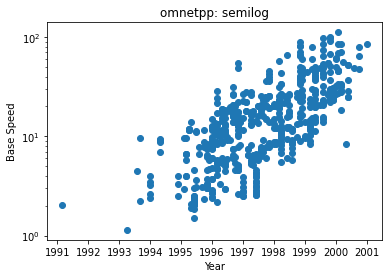

In [253]:
#plot semiplot
x = matplotlib.dates.date2num(omnetpp_merged["hwAvail"])
plt.plot_date(x, omnetpp_merged["base_y"])
plt.title("omnetpp: semilog")
plt.yscale('log')
plt.xlabel("Year")
plt.ylabel("Base Speed")

1991-03-01 00:00:00
2001-01-01 00:00:00
1.14
112.0


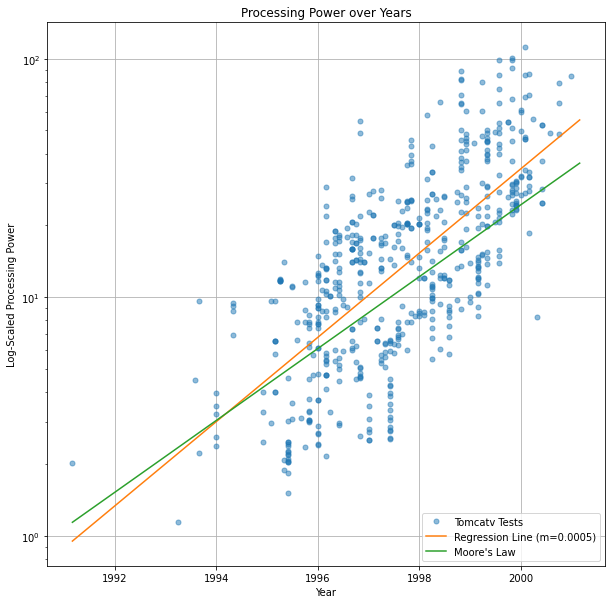

In [286]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
import numpy as np
import math

#reshaping data for sklearn
x_reshaped = np.array(x).reshape(-1,1)
y_reshaped = np.array(omnetpp_merged["base_y"]).reshape(-1,1)

#running linear regression and transformation for log-scale
model = LinearRegression()
model.fit(x_reshaped, np.log10(y_reshaped))
results = np.power(model.predict(x_reshaped),10)

#extracting data points for plotting
print(min(omnetpp_merged["hwAvail"]))
print(max(omnetpp_merged["hwAvail"]))
print(min(omnetpp_merged["base_y"]))
print(max(omnetpp_merged["base_y"]))

x_series = matplotlib.dates.date2num([datetime.date(i,3,1) for i in range(1991,2002,2)])

#plotting figure
plt.figure(figsize=[10, 10])
plt.plot_date(x_reshaped, y_reshaped, label="Tomcatv Tests", alpha=0.5, ms=5)
plt.yscale('log')
plt.plot(x_series, np.array([10**(model.coef_[0][0]*i+model.intercept_[0]) for i in x_series]), label=f"Regression Line (m={round(model.coef_[0][0],4)})")
plt.plot(x_series, [1.14,2.28,4.56,9.12,18.24,36.48], label="Moore's Law")
plt.xlabel("Year")
plt.ylabel("Log-Scaled Processing Power")
plt.title("Processing Power over Years")
plt.legend(loc="lower right")
plt.grid()

### Analysis

Based on the plot, it seems like the benchmark *101.tomactv* has been slightly underperforming in the beginning and then overperforming after around 1994 compared to Moore's Law. Thus, Moore's Law seems to hold up for this particular benchmark. It should be noted, that the linear regression assumes that negative results are possible. Hence, I added the computed negative y-intercept to each individual year to reshift the regression line.

# MNIST

In [211]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits

(array([178., 182., 177., 183., 181., 182., 181., 179., 174., 180.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

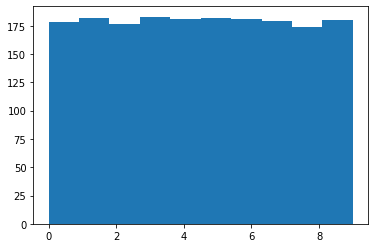

In [275]:
mnist = load_digits()
plt.hist(mnist.target)

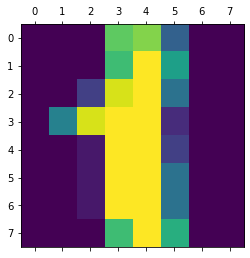

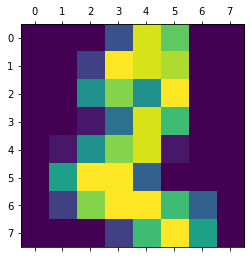

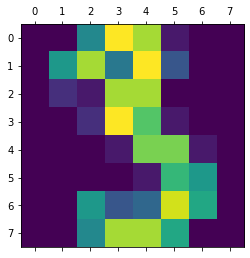

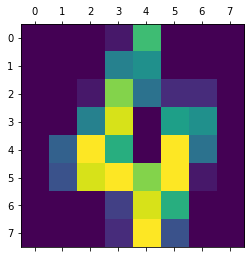

In [276]:
plt.matshow(mnist.images[1]) 
plt.matshow(mnist.images[2])
plt.matshow(mnist.images[3])
plt.matshow(mnist.images[4])

In [294]:
#extract 9 and 8
pixels = [mnist.data[i] for i in range(len(mnist.images)) if mnist.target[i] in [9,8]]
digit = [mnist.target[i] for i in range(len(mnist.images)) if mnist.target[i] in [9,8]]

In [297]:
#finding most suitable K by iterating through models with odd number of neighbours and cross-validating the model
acc = []

for n in range(1,20,2):
    model = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(model, pixels, digit, cv=5)
    acc.append(np.round(scores.mean(),3))

print([n for n in range(1,20,2)])
print(acc)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
[0.989, 0.986, 0.986, 0.983, 0.98, 0.977, 0.977, 0.975, 0.972, 0.969]


In [337]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pixels, digit, test_size=0.2, random_state=0)
print(y_train.count(9), y_train.count(8), y_test.count(9), y_test.count(8))

#training model on splitted data
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train,y_train)
y_predict = model.predict(x_test)
model.score(x_test, y_test)

147 136 33 38


0.9859154929577465

In [310]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_pred = y_predict, y_true=y_test))
print(classification_report(y_pred = y_predict, y_true=y_test))

[[38  0]
 [ 1 32]]
              precision    recall  f1-score   support

           8       0.97      1.00      0.99        38
           9       1.00      0.97      0.98        33

    accuracy                           0.99        71
   macro avg       0.99      0.98      0.99        71
weighted avg       0.99      0.99      0.99        71



<h2>Interpretation</h2>
The accuracy of the KNN is very high due to testing and training the model with the very sophisticated data set while only needing to differentiate between two digits. All three metrics – precision, recall, and accuracy – are nearly perfect. Thus, one neighbour or a simple nearest neighbour classification seems to be most suitable. If more digits had to be classified, the accuracy would be lower and most likely, more neighbours would be needed to achieve high accuracy.